In [19]:
import torch
from diffusion.model.builder import build_model, get_tokenizer_and_text_encoder, get_vae, vae_decode
from diffusion.model.utils import get_weight_dtype, prepare_prompt_ar, resize_and_crop_tensor
from diffusion.utils.config import SanaConfig, model_init_config
from diffusion.utils.logger import get_root_logger

from diffusion import DPMS_SDE
from app.sana_pipeline_tts import SanaPipeline

from tqdm import tqdm
import numpy as np
import os

from PIL import Image
from matplotlib import pyplot as plt

In [2]:
style_list = [
    {
        "name": "(No style)",
        "prompt": "{prompt}",
        "negative_prompt": "",
    },
    {
        "name": "Cinematic",
        "prompt": "cinematic still {prompt} . emotional, harmonious, vignette, highly detailed, high budget, bokeh, "
        "cinemascope, moody, epic, gorgeous, film grain, grainy",
        "negative_prompt": "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured",
    },
    {
        "name": "Photographic",
        "prompt": "cinematic photo {prompt} . 35mm photograph, film, bokeh, professional, 4k, highly detailed",
        "negative_prompt": "drawing, painting, crayon, sketch, graphite, impressionist, noisy, blurry, soft, deformed, ugly",
    },
    {
        "name": "Anime",
        "prompt": "anime artwork {prompt} . anime style, key visual, vibrant, studio anime,  highly detailed",
        "negative_prompt": "photo, deformed, black and white, realism, disfigured, low contrast",
    },
    {
        "name": "Manga",
        "prompt": "manga style {prompt} . vibrant, high-energy, detailed, iconic, Japanese comic style",
        "negative_prompt": "ugly, deformed, noisy, blurry, low contrast, realism, photorealistic, Western comic style",
    },
    {
        "name": "Digital Art",
        "prompt": "concept art {prompt} . digital artwork, illustrative, painterly, matte painting, highly detailed",
        "negative_prompt": "photo, photorealistic, realism, ugly",
    },
    {
        "name": "Pixel art",
        "prompt": "pixel-art {prompt} . low-res, blocky, pixel art style, 8-bit graphics",
        "negative_prompt": "sloppy, messy, blurry, noisy, highly detailed, ultra textured, photo, realistic",
    },
    {
        "name": "Fantasy art",
        "prompt": "ethereal fantasy concept art of  {prompt} . magnificent, celestial, ethereal, painterly, epic, "
        "majestic, magical, fantasy art, cover art, dreamy",
        "negative_prompt": "photographic, realistic, realism, 35mm film, dslr, cropped, frame, text, deformed, "
        "glitch, noise, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, "
        "disfigured, sloppy, duplicate, mutated, black and white",
    },
    {
        "name": "Neonpunk",
        "prompt": "neonpunk style {prompt} . cyberpunk, vaporwave, neon, vibes, vibrant, stunningly beautiful, crisp, "
        "detailed, sleek, ultramodern, magenta highlights, dark purple shadows, high contrast, cinematic, "
        "ultra detailed, intricate, professional",
        "negative_prompt": "painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured",
    },
    {
        "name": "3D Model",
        "prompt": "professional 3d model {prompt} . octane render, highly detailed, volumetric, dramatic lighting",
        "negative_prompt": "ugly, deformed, noisy, low poly, blurry, painting",
    },
]

styles = {k["name"]: (k["prompt"], k["negative_prompt"]) for k in style_list}

def apply_style(style_name: str, positive: str, negative: str = "") -> tuple[str, str]:
    p, n = styles.get(style_name, styles['(No style)'])
    if not negative:
        negative = ""
    return p.replace("{prompt}", positive), n + negative

In [3]:
device = torch.device('cuda:4')
config = "../configs/sana_config/1024ms/Sana_1600M_img1024.yaml"
model_path = "hf://Efficient-Large-Model/Sana_1600M_1024px_BF16/checkpoints/Sana_1600M_1024px_BF16.pth"
pipe = SanaPipeline(config, device)
pipe.from_pretrained(model_path)

2025-08-04 14:01:19 - [Sana] - INFO - Sampler flow_dpm-solver, flow_shift: 3.0
2025-08-04 14:01:19 - [Sana] - INFO - Inference with torch.bfloat16, PAG guidance layer: [8]


[AutoencoderDC] Loading model from mit-han-lab/dc-ae-f32c32-sana-1.1-diffusers


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]
2025-08-04 14:01:38 - [Sana] - INFO - use pe: False, pos embed type: sincos, position embed interpolation: 1.0, base size: 32
2025-08-04 14:01:38 - [Sana] - INFO - attention type: linear; ffn type: glumbconv; self-attn qk norm: False; cross-attn type: flash;  cross-attn qk norm: False; autocast linear attn: False
2025-08-04 14:01:57 - [Sana] - INFO - use_fp32_attention: False
2025-08-04 14:01:57 - [Sana] - INFO - SanaMS:SanaMS_1600M_P1_D20,Model Parameters: 1,604,462,752
Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 19996.68it/s]


[Sana] Loading model from /home/hyunmo/.cache/huggingface/hub/models--Efficient-Large-Model--Sana_1600M_1024px_BF16/snapshots/cd38585439bdef94466144ecfa46b3c1c7b35957/checkpoints/Sana_1600M_1024px_BF16.pth


2025-08-04 14:02:04 - [Sana] - INFO - Generating sample from ckpt: hf://Efficient-Large-Model/Sana_1600M_1024px_BF16/checkpoints/Sana_1600M_1024px_BF16.pth
2025-08-04 14:02:04 - [Sana] - WARNING - Missing keys: ['pos_embed']
2025-08-04 14:02:04 - [Sana] - WARNING - Unexpected keys: []


In [21]:
def egreedy(
    self,
    x,
    steps=20,
    t_start=None,
    t_end=None,
    order=2,
    skip_type="time_uniform",
    lower_order_final=True,
    solver_type="dpmsolver",
    flow_shift=1.0,
):
    t_0 = 1.0 / self.noise_schedule.total_N if t_end is None else t_end
    t_T = self.noise_schedule.T if t_start is None else t_start

    device = x.device

    with torch.no_grad():
        timesteps = self.get_time_steps(
            skip_type=skip_type, t_T=t_T, t_0=t_0, N=steps, device=device, shift=flow_shift
        )

        step = 0
        t = timesteps[step]
        t_prev_list = [t]
        model_prev_list = [self.model_fn(x, t)]

        if self.correcting_xt_fn is not None:
            x = self.correcting_xt_fn(x, t, step)

        self.update_progress(step + 1, len(timesteps))

        for step in tqdm(range(1, steps + 1), disable=os.getenv("DPM_TQDM", "False") == "True"):
            t = timesteps[step]

            if step == 1 or (step == steps and lower_order_final):
                step_order = 1
            else:
                step_order = order

            x = self.multistep_dpm_solver_update(
                x, model_prev_list, t_prev_list, t, step_order, solver_type=solver_type
            )
            if self.correcting_xt_fn is not None:
                x = self.correcting_xt_fn(x, t, step)

            t_prev_list = [t_prev_list[-1], t]
            model_prev_list = [model_prev_list[-1], self.model_fn(x, t)]

            self.update_progress(step + 1, len(timesteps))

    return x

In [ ]:
def guidance_type_select(default_guidance_type, pag_scale, attn_type):
    guidance_type = default_guidance_type
    if not (pag_scale > 1.0 and attn_type == "linear"):
        guidance_type = "classifier-free"
    elif pag_scale > 1.0 and attn_type == "linear":
        guidance_type = "classifier-free_PAG"
    return guidance_type


def classify_height_width_bin(height: int, width: int, ratios: dict):
    """Returns binned height and width."""
    ar = float(height / width)
    closest_ratio = min(ratios.keys(), key=lambda ratio: abs(float(ratio) - ar))
    default_hw = ratios[closest_ratio]
    return int(default_hw[0]), int(default_hw[1])

@torch.inference_mode()
def generate_image(
    self,
    prompt=None,
    height=1024,
    width=1024,
    negative_prompt="",
    num_inference_steps=20,
    guidance_scale=4.5,
    pag_guidance_scale=1.0,
    generator=torch.Generator().manual_seed(42),
    latents=None,
    use_resolution_binning=True,
):
    self.ori_height, self.ori_width = height, width
    if use_resolution_binning:
        self.height, self.width = classify_height_width_bin(height, width, ratios=self.base_ratios)
    else:
        self.height, self.width = height, width
    self.latent_size_h, self.latent_size_w = (
        self.height // self.config.vae.vae_downsample_rate,
        self.width // self.config.vae.vae_downsample_rate,
    )
    self.guidance_type = guidance_type_select(self.guidance_type, pag_guidance_scale, self.config.model.attn_type)

    if negative_prompt != "":
        null_caption_token = self.tokenizer(
            negative_prompt,
            max_length=self.max_sequence_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        ).to(self.device)
        self.null_caption_embs = self.text_encoder(null_caption_token.input_ids, null_caption_token.attention_mask)[
            0
        ]

    if prompt is None:
        prompt = ""
    
    hw, ar = (
        torch.tensor([[self.image_size, self.image_size]], dtype=torch.float, device=self.device),
        torch.tensor([[1.0]], device=self.device),
    )

    prompt = prepare_prompt_ar(prompt, self.base_ratios, device=self.device, show=False)[0].strip()

    with torch.no_grad():
        if not self.config.text_encoder.chi_prompt:
            max_length_all = self.config.text_encoder.model_max_length
            prompts_all = prompt
        else:
            chi_prompt = "\n".join(self.config.text_encoder.chi_prompt)
            prompts_all = chi_prompt + prompt
            num_chi_prompt_tokens = len(self.tokenizer.encode(chi_prompt))
            max_length_all = (
                num_chi_prompt_tokens + self.config.text_encoder.model_max_length - 2
            )

        caption_token = self.tokenizer(
            prompts_all,
            max_length=max_length_all,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        ).to(device=self.device)

        select_index = [0] + list(range(-self.config.text_encoder.model_max_length + 1, 0))
        caption_embs = self.text_encoder(caption_token.input_ids, caption_token.attention_mask)[0][:, None][
            :, :, select_index
        ].to(self.weight_dtype)
        emb_masks = caption_token.attention_mask[:, select_index]
        null_y = self.null_caption_embs[:, None].to(self.weight_dtype)

        if latents is None:
            z = torch.randn(
                1,
                self.config.vae.vae_latent_dim,
                self.latent_size_h,
                self.latent_size_w,
                generator=generator,
                device=self.device,
            )
        else:
            z = latents.to(self.device)

        model_kwargs = dict(data_info={"img_hw": hw, "aspect_ratio": ar}, mask=emb_masks)

        scheduler = DPMS_SDE(
            self.model,
            condition=caption_embs,
            uncondition=null_y,
            guidance_type=self.guidance_type,
            cfg_scale=guidance_scale,
            pag_scale=pag_guidance_scale,
            pag_applied_layers=self.config.model.pag_applied_layers,
            model_type="flow",
            model_kwargs=model_kwargs,
            schedule="FLOW",
        )

        scheduler.register_progress_bar(self.progress_fn)

        # sample = egreedy(
        #     scheduler,
        #     z,
        #     steps=num_inference_steps,
        #     order=2,
        #     skip_type="time_uniform_flow",
        #     flow_shift=self.flow_shift,
        # )

        sample = scheduler.sample(
            z,
            steps=num_inference_steps,
            order=1,
            skip_type="time_uniform_flow",
            method="multistep",
            flow_shift=self.flow_shift,
        )


    sample = sample.to(self.vae_dtype)
    
    with torch.no_grad():
        sample = vae_decode(self.config.vae.vae_type, self.vae, sample)
        sample = sample.clip(-1, 1)
        sample = (sample + 1) * 0.5

    if use_resolution_binning:
        sample = resize_and_crop_tensor(sample, self.ori_width, self.ori_height)

    print(sample.max(), sample.min())

    return sample

In [ ]:
@torch.no_grad()
@torch.inference_mode()
def generate(
    prompt: str = None,
    negative_prompt: str = "",
    style: str = '(No style)',
    use_negative_prompt: bool = False,
    seed: int = 0,
    height: int = 1024,
    width: int = 1024,
    flow_dpms_guidance_scale: float = 5.0,
    flow_dpms_pag_guidance_scale: float = 2.0,
    flow_dpms_inference_steps: int = 20,
):
    generator = torch.Generator(device=device).manual_seed(seed)

    print(prompt)

    num_inference_steps = flow_dpms_inference_steps
    guidance_scale = flow_dpms_guidance_scale
    pag_guidance_scale = flow_dpms_pag_guidance_scale

    if not use_negative_prompt:
        negative_prompt = None  # type: ignore
        
    prompt, negative_prompt = apply_style(style, prompt, negative_prompt)

    pipe.progress_fn(0, desc="Sana Start")

    images = generate_image(
        pipe,
        prompt=prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        guidance_scale=guidance_scale,
        pag_guidance_scale=pag_guidance_scale,
        num_inference_steps=num_inference_steps,
        generator=generator,
    )

    pipe.progress_fn(1.0, desc="Sana End")

    img = [
            img
            .permute(1, 2, 0)
            .to("cpu")
            .numpy()

        for img in images
    ]

    torch.cuda.empty_cache()

    return img

hello world


100%|██████████| 5/5 [00:00<00:00,  6.80it/s]


tensor(1.1568, device='cuda:4') tensor(-1.3737, device='cuda:4')


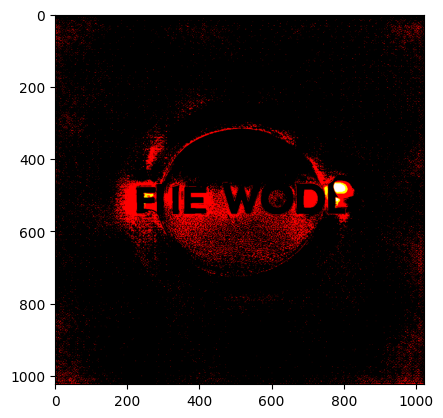

In [47]:
from matplotlib import pyplot as plt

ret = generate('hello world', flow_dpms_inference_steps=5)
plt.imshow(ret[0])

In [42]:
ret[0].max(), ret[0].min()

(np.uint8(255), np.uint8(0))